##  Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    train.csv - the training set (all tickets issued 2004-2011)
    test.csv - the test set (all tickets issued 2012-2016)
    addresses.csv & latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


In [8]:
import pandas as pd
import numpy as np

def blight_model():
    
    # Your code here
    def load_data():
        df_train = pd.read_csv('train.csv', encoding='iso-8859-1', index_col=0)
        df_test = pd.read_csv('test.csv', encoding='iso-8859-1', index_col=0)
        df_addr = pd.read_csv('addresses.csv')
        df_latlon = pd.read_csv('latlons.csv')

        # print(df_addr.head(), '\n', df_latlon.head(), df_addr.shape, df_latlon.shape)
        # def f(s):
        #     return str.isdigit(s[-1])
        # df_latlon[df_latlon.address.apply(f)], df_addr[df_addr.address.apply(f)]
        df_map = pd.merge(df_addr, df_latlon, on='address', how='left') # .dropna(axis=0)
        df_map = df_map.set_index('ticket_id')
        # df_map[df_map.lat.isnull()]

        df_map_test = pd.merge(df_test, df_map, left_index=True, right_index=True, how='left')
        df_map_train = pd.merge(df_train, df_map, left_index=True, right_index=True, how='left')

        # df_map_train[df_map_train.lon.isnull()]
        return df_map_train, df_map_test

    def clean_data(df_map_train, df_map_test):    
        from sklearn.preprocessing import LabelEncoder
        from collections import Counter
        # print(Counter(LabelEncoder().fit_transform(df_map_train.violation_code)))
        # print(df_map_train.columns, '\n', df_map_test.columns)
        # print(df_map_train.shape, df_map_test.shape)
        df_map_train['violation_label'] = LabelEncoder().fit_transform(df_map_train.violation_code)
        df_map_test['violation_label'] = LabelEncoder().fit_transform(df_map_test.violation_code)
        df_map_train['agency_label'] = LabelEncoder().fit_transform(df_map_train.agency_name)
        df_map_test['agency_label'] = LabelEncoder().fit_transform(df_map_test.agency_name)

        from datetime import datetime
        def date_gap(df_train):
            gap_mean = np.mean(pd.to_datetime(df_train.hearing_date, format="%Y-%m-%d %H:%M:%S")
                                - pd.to_datetime(df_train.ticket_issued_date, format="%Y-%m-%d %H:%M:%S")) 
            gap = (pd.to_datetime(df_train.hearing_date, format="%Y-%m-%d %H:%M:%S")
                        - pd.to_datetime(df_train.ticket_issued_date, format="%Y-%m-%d %H:%M:%S"))
            df_train['gap'] = gap.dt.days
            df_train.loc[df_train.gap.isnull(), 'gap'] = 76
            return df_train['gap']

        # df_map_train['gap'] = date_gap(df_map_train)
        # df_map_test['gap'] = date_gap(df_map_test)
        
        def time_gap(hearing_date_str, ticket_issued_date_str):
            if not hearing_date_str or type(hearing_date_str)!=str: return 76
            hearing_date = datetime.strptime(hearing_date_str, "%Y-%m-%d %H:%M:%S")
            ticket_issued_date = datetime.strptime(ticket_issued_date_str, "%Y-%m-%d %H:%M:%S")
            gap = hearing_date - ticket_issued_date
            return gap.days

        df_map_train['gap'] = df_map_train.apply(lambda row: time_gap(row['hearing_date'], row['ticket_issued_date']), axis=1)
        df_map_test['gap'] = df_map_test.apply(lambda row: time_gap(row['hearing_date'], row['ticket_issued_date']), axis=1)
        # date_gap(df_train['hearing_date'][4], df_train['ticket_issued_date'][4])
        # datetime.strptime(df_train.ticket_issued_date[1], "%Y-%m-%d %H:%M:%S")

        return df_map_train, df_map_test    
    
    
    df_map_train, df_map_test = load_data()
    df_map_train, df_map_test = clean_data(df_map_train, df_map_test)
    '''from IPython.core.display import display
    display(df_map_train.head(1))
    display(df_map_test.head(1))'''
    

    cols_keep = [ 'agency_label', 
    #                'mailing_address_str_number',
    #                'mailing_address_str_name', 'city', 'state', 
               'gap',
               'violation_label', 'fine_amount',
                'late_fee', 'judgment_amount']
    # df_map_test[cols_keep]
    
    from sklearn.model_selection import train_test_split
    from sklearn.dummy import DummyClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import auc, accuracy_score
    X = df_map_train.loc[df_map_train.compliance.notnull(), cols_keep]
    y = df_map_train.loc[df_map_train.compliance.notnull(), 'compliance'].apply(bool)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    # clf = DummyClassifier(strategy='stratified', random_state=1)
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    # print(clf.score(X_train, y_train))
    # print(clf.score(X_test, y_test))
    
    df_map_test['compliance']= clf.predict_proba(df_map_test.loc[:, cols_keep])[:, 1]
    
    return df_map_test['compliance'].astype('float32')  # Your answer here

In [ ]:
# df = blight_model()
# df[:5]

In [ ]:
import pandas as pd
import numpy as np
def load_data():
    df_train = pd.read_csv('train.csv', encoding='iso-8859-1', index_col=0)
    df_test = pd.read_csv('test.csv', encoding='iso-8859-1', index_col=0)
    df_addr = pd.read_csv('addresses.csv')
    df_latlon = pd.read_csv('latlons.csv')

    # print(df_addr.head(), '\n', df_latlon.head(), df_addr.shape, df_latlon.shape)
    # def f(s):
    #     return str.isdigit(s[-1])
    # df_latlon[df_latlon.address.apply(f)], df_addr[df_addr.address.apply(f)]
    df_map = pd.merge(df_addr, df_latlon, on='address', how='left') # .dropna(axis=0)
    df_map = df_map.set_index('ticket_id')
    # df_map[df_map.lat.isnull()]

    df_map_test = pd.merge(df_test, df_map, left_index=True, right_index=True, how='left')
    df_map_train = pd.merge(df_train, df_map, left_index=True, right_index=True, how='left')

    # df_map_train[df_map_train.lon.isnull()]
    return df_map_train, df_map_test

def clean_data(df_map_train, df_map_test):    
    from sklearn.preprocessing import LabelEncoder
    from collections import Counter
    # print(Counter(LabelEncoder().fit_transform(df_map_train.violation_code)))
    # print(df_map_train.columns, '\n', df_map_test.columns)
    # print(df_map_train.shape, df_map_test.shape)
    df_map_train['violation_label'] = LabelEncoder().fit_transform(df_map_train.violation_code)
    df_map_test['violation_label'] = LabelEncoder().fit_transform(df_map_test.violation_code)
    df_map_train['agency_label'] = LabelEncoder().fit_transform(df_map_train.agency_name)
    df_map_test['agency_label'] = LabelEncoder().fit_transform(df_map_test.agency_name)
    
    from datetime import datetime
    def date_gap(df_train):
        gap_mean = np.mean(pd.to_datetime(df_train.hearing_date, format="%Y-%m-%d %H:%M:%S")
                            - pd.to_datetime(df_train.ticket_issued_date, format="%Y-%m-%d %H:%M:%S")) 
        gap = (pd.to_datetime(df_train.hearing_date, format="%Y-%m-%d %H:%M:%S")
                    - pd.to_datetime(df_train.ticket_issued_date, format="%Y-%m-%d %H:%M:%S"))
        df_train['gap'] = gap.dt.days
        df_train.loc[df_train.gap.isnull(), 'gap'] = 76
        return df_train['gap']

    # df_map_train['gap'] = date_gap(df_map_train)
    # df_map_test['gap'] = date_gap(df_map_test)   
    def time_gap(hearing_date_str, ticket_issued_date_str):
        if not hearing_date_str or type(hearing_date_str)!=str: return 76
        hearing_date = datetime.strptime(hearing_date_str, "%Y-%m-%d %H:%M:%S")
        ticket_issued_date = datetime.strptime(ticket_issued_date_str, "%Y-%m-%d %H:%M:%S")
        gap = hearing_date - ticket_issued_date
        return gap.days
    
    df_map_train['gap'] = df_map_train.apply(lambda row: time_gap(row['hearing_date'], row['ticket_issued_date']), axis=1)
    df_map_test['gap'] = df_map_test.apply(lambda row: time_gap(row['hearing_date'], row['ticket_issued_date']), axis=1)
    # date_gap(df_train['hearing_date'][4], df_train['ticket_issued_date'][4])
    # datetime.strptime(df_train.ticket_issued_date[1], "%Y-%m-%d %H:%M:%S")
    return df_map_train, df_map_test

    

df_map_train, df_map_test = load_data()
df_map_train, df_map_test = clean_data(df_map_train, df_map_test)

cols_keep = [ 'agency_label', 
#                'mailing_address_str_number',
#                'mailing_address_str_name', 'city', 'state', 
           'gap',
           'violation_label', 'fine_amount',
            'late_fee', 'judgment_amount']
# df_map_test[cols_keep]

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, accuracy_score
X = df_map_train.loc[df_map_train.compliance.notnull(), cols_keep]
y = df_map_train.loc[df_map_train.compliance.notnull(), 'compliance'].apply(bool)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
# clf = DummyClassifier(strategy='stratified', random_state=1)
clf = LogisticRegression()
clf.fit(X_train, y_train)
# print(clf.score(X_train, y_train))
# print(clf.score(X_test, y_test))

df_map_test['compliance'] = clf.predict_proba(df_map_test.loc[:, cols_keep])[:, 1]
df_map_test['compliance'].astype('float32')

In [12]:

df_map_train, df_map_test = load_data()
df_map_train, df_map_test = clean_data(df_map_train, df_map_test)
cols_keep = [ 'agency_label', 
#                'mailing_address_str_number',
#                'mailing_address_str_name', 'city', 'state', 
           'gap',
           'violation_label', 'fine_amount',
            'late_fee', 'judgment_amount']
df_map_test[cols_keep]

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, accuracy_score
X = df_map_train.loc[df_map_train.compliance.notnull(), cols_keep]
y = df_map_train.loc[df_map_train.compliance.notnull(), 'compliance'].apply(bool)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
# clf = DummyClassifier(strategy='stratified', random_state=1)
clf = LogisticRegression()
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))
y_score_lr = clf.decision_function(X_test)
from sklearn.metrics import roc_curve, auc
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

/opt/conda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


0.927053623551
0.927645734301


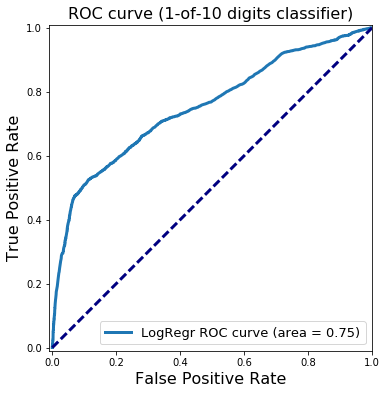

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

In [ ]:
import pandas as pd
import numpy as np

def blight_model2():
    from sklearn.neural_network import MLPClassifier
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.tree import DecisionTreeClassifier
    from datetime import datetime
    def time_gap(hearing_date_str, ticket_issued_date_str):
        if not hearing_date_str or type(hearing_date_str)!=str: return 73
        hearing_date = datetime.strptime(hearing_date_str, "%Y-%m-%d %H:%M:%S")
        ticket_issued_date = datetime.strptime(ticket_issued_date_str, "%Y-%m-%d %H:%M:%S")
        gap = hearing_date - ticket_issued_date
        return gap.days
    train_data = pd.read_csv('train.csv', encoding = 'ISO-8859-1')
    test_data = pd.read_csv('test.csv')
    train_data = train_data[(train_data['compliance'] == 0) | (train_data['compliance'] == 1)]
    address =  pd.read_csv('addresses.csv')
    latlons = pd.read_csv('latlons.csv')
    address = address.set_index('address').join(latlons.set_index('address'), how='left')
    train_data = train_data.set_index('ticket_id').join(address.set_index('ticket_id'))
    test_data = test_data.set_index('ticket_id').join(address.set_index('ticket_id'))
    train_data = train_data[~train_data['hearing_date'].isnull()]
    train_data['time_gap'] = train_data.apply(lambda row: time_gap(row['hearing_date'], row['ticket_issued_date']), axis=1)
    test_data['time_gap'] = test_data.apply(lambda row: time_gap(row['hearing_date'], row['ticket_issued_date']), axis=1)
    feature_to_be_splitted = ['agency_name', 'state', 'disposition']
    train_data.lat.fillna(method='pad', inplace=True)
    train_data.lon.fillna(method='pad', inplace=True)
    train_data.state.fillna(method='pad', inplace=True)

    test_data.lat.fillna(method='pad', inplace=True)
    test_data.lon.fillna(method='pad', inplace=True)
    test_data.state.fillna(method='pad', inplace=True)
    train_data = pd.get_dummies(train_data, columns=feature_to_be_splitted)
    test_data = pd.get_dummies(test_data, columns=feature_to_be_splitted)
    list_to_remove_train = [
        'balance_due',
        'collection_status',
        'compliance_detail',
        'payment_amount',
        'payment_date',
        'payment_status'
    ]
    list_to_remove_all = ['fine_amount', 'violator_name', 'zip_code', 'country', 'city',
                          'inspector_name', 'violation_street_number', 'violation_street_name',
                          'violation_zip_code', 'violation_description',
                          'mailing_address_str_number', 'mailing_address_str_name',
                          'non_us_str_code',
                          'ticket_issued_date', 'hearing_date', 'grafitti_status', 'violation_code']
    train_data.drop(list_to_remove_train, axis=1, inplace=True)
    train_data.drop(list_to_remove_all, axis=1, inplace=True)
    test_data.drop(list_to_remove_all, axis=1, inplace=True)
    train_features = train_data.columns.drop('compliance')
    train_features_set = set(train_features)
    
    for feature in set(train_features):
        if feature not in test_data:
            train_features_set.remove(feature)
    train_features = list(train_features_set)
    
    X_train = train_data[train_features]
    y_train = train_data.compliance
    X_test = test_data[train_features]
    
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
#     clf = MLPClassifier(hidden_layer_sizes = [100, 10], alpha = 5,
#                        random_state = 0, solver='lbfgs', verbose=0)
    clf = DecisionTreeClassifier()
    clf.fit(X_train_scaled, y_train)

    test_proba = clf.predict_proba(X_test_scaled)[:,1]

    
    test_df = pd.read_csv('test.csv', encoding = "ISO-8859-1")
    test_df['compliance'] = test_proba
    test_df.set_index('ticket_id', inplace=True)
    
    return test_df.compliance

In [ ]:
# df2 = blight_model()

In [ ]:
# df_train['date_gap'] = df_train.apply((lambda row: date_gap(row['hearing_date'], row['ticket_issued_date']), axis=1)
# df_train.date_gap.head()
# df_map_test['compliance']= clf.predict_proba(df_map_test.loc[:, cols_keep])[:, 1]
# df_map_test['compliance']

In [ ]:
# set(df.columns) - set(df_test.columns)
# Counter(df_test.zip_code).most_common(30)
# sorted(df_test.zip_code.astype(str), key=len)
# Counter(df_test.violation_code).most_common(20)

In [ ]:
# (Counter(df_train.clean_up_cost).most_common(10), 
# df_test.grafitti_status.unique())
# (Counter(df.compliance[df.compliance.notnull()]), Counter(df.city).most_common(10))

In [ ]:
X_train.shape
X_train.describe()

In [ ]:
X_test.describe()